# Sentiment Polarity Analysis for Amazon Food Review
This project explored the sentiment of users of 568,454 amazon food reviews. At the begining, a study was conducted at a single user level on the language patterns contributes to the sentiment of this user in all her amazon food reviews. 

Futhermore, to analyze all the reviews as a whole, machine learning approaches was used for classifying sentiment polarities all the reviews. After preprocessing the data using nltk and conducting feature engineering, a comparison of classification performance was made to eight different classification algorithms and the best model (by comparing the ROC curve) was achieved by Support Vector Machine (SVM).

In [1]:
# import packages maybe used later
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from itertools import chain
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
warnings.filterwarnings('ignore')

In [2]:
# read data from csv file
# Attention: modify file path when running in a different environment
df = pd.read_csv('Reviews.csv')

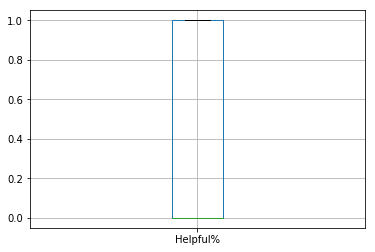

In [3]:
### Construct feature 'helpfulness'
df['Helpful%'] = np.where(df['HelpfulnessDenominator'] > 0, df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], 0)

## Clean dirty data with outliers in 'helpful'
indexNames = df[ (df['Helpful%'] == 3) | (df['Helpful%'] == 1.5) ].index
df.drop(indexNames , inplace=True)
df[['Score', 'Helpful%']].describe()

df[['Helpful%']].boxplot()

In [4]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful%
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0


In [5]:
## Clean dirty data with outliers in 'helpful'
indexNames = df[ (df['Helpful%'] == 3) | (df['Helpful%'] == 1.5) ].index
df.drop(indexNames , inplace=True)
df[['Score', 'Helpful%']].describe()

,Score,Helpful%
count,568452.000000,568452.000000
mean,4.183198,0.407855
std,1.310438,0.462054
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,1.000000
max,5.000000,1.000000


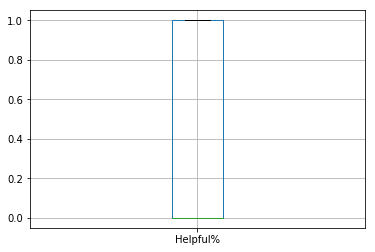

In [6]:
df[['Helpful%']].boxplot()

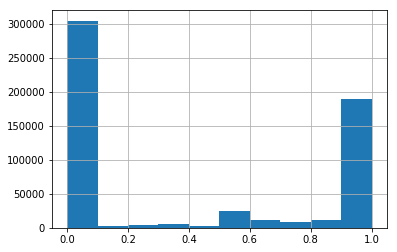

In [7]:
### Distribution of the constructed feature 'Helpfulness'
df['Helpful%'].hist()

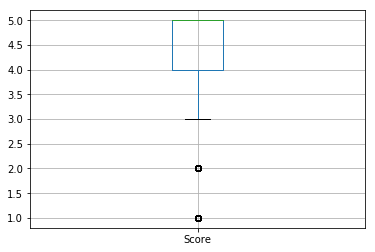

In [8]:
### Distribution of the raw class label
df[['Score']].boxplot()

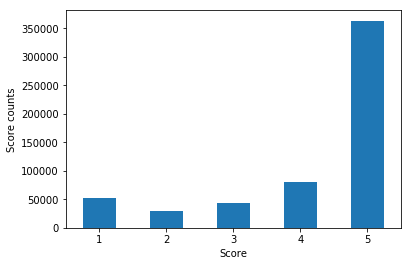

In [9]:
plt.figure()
count_classes=pd.value_counts(df['Score'], sort=False)
count_classes.plot(kind='bar',rot=0)
plt.xlabel('Score')
plt.ylabel('Score counts')
plt.savefig("Amazon_food_review.png")

## Analyses on a single user level

In [10]:
#Finding users with the number of reviews they gave as well as the average score they gave
df_user = df.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


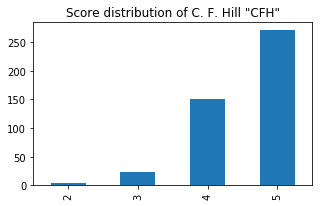

In [11]:
def plot_user(UserId):
    df_1user = df[df['UserId'] == UserId]['Score']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (5,3), title = 'Score distribution of {}'.format(df[df['UserId'] == UserId]['ProfileName'].iloc[0]))
plot_user('A3OXHLG6DIBRW8')
### It seems that C.F.Hill tends only to give high score, so we set a boundary on the review scores 
### to find a 'fairer' customer
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

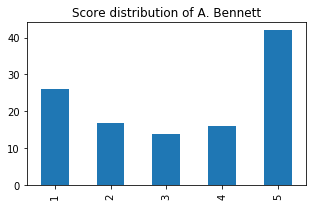

In [12]:
plot_user('A2M9D9BDHONV3Y')
## He is much more mutual in giving scores

In [13]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df1 = df[(df['UserId'] == userid) & (df['Score'] == score)]['Text']
    else:
        df1 = df[df['Score'] == score]['Text']
        
    count = len(df1)
    total_text = ' '.join(df1)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)
    
### However, this table(left) is not very useful 
### because we can not get a user's preference from words like “never buy” and “highly recommend”. 

score 1 reviews most popular 2-gram / 3-gram:
   Count  Occur %                   Phrase
0   31.0  119.23%               (..., ...)
1   17.0   65.38%          (..., ..., ...)
2   11.0   42.31%             (never, buy)
3    9.0   34.62%           (buy, product)
4    8.0   30.77%  (monosodium, glutamate)
5    8.0   30.77%    (never, buy, product)
6    7.0   26.92%         (dry, tasteless)
7    7.0   26.92%            (decide, try)
8    7.0   26.92%          (picture, look)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %                Phrase
0     8.0  47.06%         (ruin, whole)
1     8.0  47.06%  (sauce, ruin, whole)
2     8.0  47.06%         (sauce, ruin)
3     6.0  35.29%            (n't, buy)
4     6.0  35.29%       (product, ever)
5     5.0  29.41%         (taste, like)
6     5.0  29.41%    (.give, try, like)
7     5.0  29.41%            (n't, get)
8     5.0  29.41%          (get, wrong)
9     5.0  29.41%     (n't, get, wrong)
10    5.0  29.41%          (..., .give

In [14]:
### In order to discover more useful information, we only analyze the adjective words from reviews. 
### The new table(right) is the most frequent adjective words that “A.Bennett” would like to use.
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df2 = df[(df['UserId'] == userid) & (df['Score'] == score)]['Text']
    else:
        df2 = df[df['Score'] == score]['Text']
        
    count = len(df2)
    total_text = ' '.join(df2)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

In [15]:
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
   Count Occur %     Phrase
0   13.0   50.0%        dry
1   12.0  46.15%     cheese
2   10.0  38.46%        bad
3   10.0  38.46%     little
4    8.0  30.77%  delicious
5    8.0  30.77%       hard
6    8.0  30.77%  expensive
7    8.0  30.77%      tasty
8    7.0  26.92%       poor
9    7.0  26.92%      bread
score 2 reviews most popular adjectives word:
   Count Occur %      Phrase
0   10.0  58.82%       whole
1    8.0  47.06%      cheese
2    6.0  35.29%   delicious
3    6.0  35.29%       wrong
4    6.0  35.29%       awful
5    5.0  29.41%       .give
6    5.0  29.41%        good
7    5.0  29.41%  particular
score 3 reviews most popular adjectives word:
   Count Occur %        Phrase
0    9.0  64.29%         whole
1    5.0  35.71%          high
2    4.0  28.57%  disappointed
3    4.0  28.57%         first
4    4.0  28.57%         great
5    4.0  28.57%          good
score 4 reviews most popular adjectives word:
   Count Occur %     Phrase
0 

## Analysis on the entire review -- a machine learning approach
We selected algorithms such as naive bayes, logistic regression, support vector machine, decision tree, GBDT, neural network, in our comparison. Following is the parameter setting of those classifiers.

As the dataset is imbalanced which has 354,975 positive reviews as opposed to 65676 negative reviews, we used AUC ROC (Area Under Curve -Receiver Operator Characteristic) to evaluate model performance as it is an unbiased estimation of the probability prediction of the classifier, with a consideration of the balance between true positive rate and false positive rate.

#### Prepare Dataset for machine learning

In [16]:
### abandon reviews whose score is 3
df = df[df['Score'] != 3]
temp_dict = {1:0, 2:0, 4:1, 5:1} 
### Define class label
df['Sentiment'] = df['Score'].map(temp_dict)

In [17]:
#### Data Cleaning
cleanup_re = re.compile('[^a-z]+') # Regular expression to filter non-alpha characters 
html_cleaner = re.compile('<.*?>') # To filter html tags
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    sentence = html_cleaner.sub(' ', sentence).strip()
    sentence = sentence.replace('www','')
    sentence = sentence.replace('http','')
    sentence = sentence.replace('href','')
    return sentence

df['Text_Clean'] = df['Text'].apply(cleanup)

### Vectorization using tf - idf technique
tfidf_vec = TfidfVectorizer(min_df = 1, max_features = 500, ngram_range = (1, 2), stop_words='english')

In [18]:
# Train - test split for machine learning models
def vectorize(vec):
    X_tfidf = tfidf_vec.fit_transform(df["Text_Clean"])
    Y_sentiment = df['Sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y_sentiment, test_size=0.2)
    print('Number of features: {}'.format(X_tfidf.shape[1]))
    print('Number of instances in train set: {}'.format(X_train.shape[0]))
    print('Number of instances in test set: {}'.format(X_test.shape[0]))
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = vectorize(tfidf_vec)

Number of features: 500
Number of instances in train set: 420649
Number of instances in test set: 105163


In [19]:
y_train.value_counts()

1    355120
0     65529
Name: Sentiment, dtype: int64

### Building Architecture for performance comparison using ROC

In [20]:
### Build dictionary to store predictions from all models
prediction = {}

#### Construct different models and make prediction

In [21]:
### Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)  ### C is regularization strength
logreg_result = logreg.fit(X_train, y_train)
prediction['Logistic'] = logreg.predict(X_test)

In [22]:
### Naive Bayes
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train, y_train)
prediction['Multinomial'] = model.predict(X_test)

from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train, y_train)
prediction['Bernoulli'] = model.predict(X_test)

In [23]:
### Neural Network - MLP
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=30, alpha=0.01, learning_rate_init=0.05, verbose=True).fit(X_train, y_train)
prediction['Nueral Network'] = mlp.predict(X_test)


Iteration 1, loss = 0.29288064
Iteration 2, loss = 0.28331570
Iteration 3, loss = 0.28353891
Iteration 4, loss = 0.28320364
Iteration 5, loss = 0.28283181
Iteration 6, loss = 0.28322124
Iteration 7, loss = 0.28345198
Iteration 8, loss = 0.28296764
Iteration 9, loss = 0.28308024
Iteration 10, loss = 0.28306917
Iteration 11, loss = 0.28325243
Iteration 12, loss = 0.28291507
Iteration 13, loss = 0.28306940
Iteration 14, loss = 0.28313425
Iteration 15, loss = 0.28290368
Iteration 16, loss = 0.28310244
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [24]:
### SVM
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
SGD=SGDClassifier(alpha=0.01)
svm=CalibratedClassifierCV(SGD, cv=3)
svm_model = svm.fit(X_train,y_train)
prediction['svm']=svm_model.predict_proba(X_test)[:,1]

In [25]:
### Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(max_depth=50,min_samples_split=500)
model = dt.fit(X_train,y_train)
prediction['Decision Tree']=model.predict_proba(X_test)[:,1]

In [26]:
### Gradient Boosted Decision Tree
from sklearn.ensemble import GradientBoostingClassifier
GBDT = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
prediction['GBDT'] = GBDT.predict_proba(X_test)[:,1]

In [27]:
### Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 50, max_depth = 50).fit(X_train, y_train)
prediction['Random_Forest'] = rfc.predict(X_test)

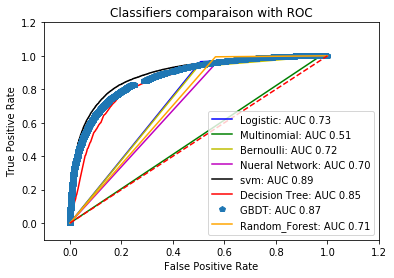

<Figure size 14400x14400 with 0 Axes>

In [28]:
### Compare ROC curve all different classifiers
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k', 'r', 'p','orange']
prediction.keys()
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.figure(figsize=(200.0,200.0))
plt.show()

### Interpretability of Support Vector Machine outcome

In [29]:
#top 10 positive features
all_features = tfidf_vec.get_feature_names()
model=SGDClassifier(alpha=1)
model.fit(X_train,y_train)
weight=model.coef_
pos_indx=np.argsort(weight)[:,::-1]
neg_indx=np.argsort(weight)
print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])

Top 10 positive features :
br
great
good
love
coffee
tea
like
flavor
just
best


In [30]:
#top 10 negative features
print('Top 10 negative features :')
for i in list(neg_indx[0][0:10]):
    print(all_features[i])

Top 10 negative features :
disappointed
opened
money
ingredient
guess
tastes like
maybe
wouldn
star
looked
